In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg


In [3]:
file = 'data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


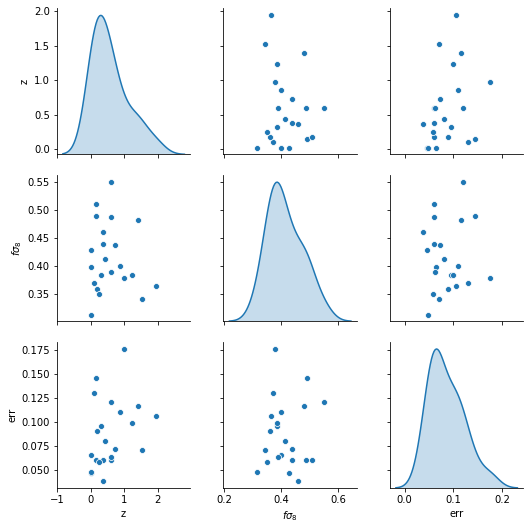

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
even = [x for x in range(len(data.values)) if x%2 ==0]
odd = [x for x in range(len(data.values)) if x%2 ==1]
even.extend(odd)
order = np.array(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[order]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])
order

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20,  1,  3,  5,  7,  9, 11,
       13, 15, 17, 19, 21])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()
initializer =tf.keras.initializers.RandomNormal

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast

batch_size = 4
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [12]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [13]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0808 - val_loss: 0.0533
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0693
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0624
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0206 - val_loss: 0.0494
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0363
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0213
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0145
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0179
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0162
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0113
Epoch 11/100
5/5 [==========

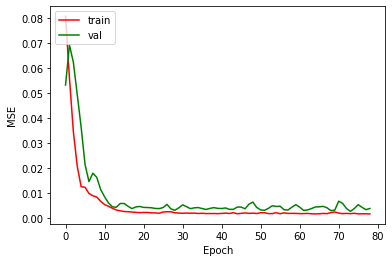

In [14]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_fs83.png", dpi=200)


In [15]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])


(0.0025415148120373483, 0.0015127755468711257)

In [16]:
pred = neural_model.predict(z_test)
pred

array([[0.47531217, 0.10343094],
       [0.47531217, 0.10343094],
       [0.36712834, 0.11292843],
       [0.38229588, 0.1138216 ],
       [0.32484293, 0.11262733]], dtype=float32)

In [17]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [18]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


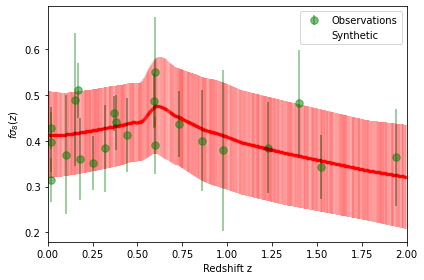

In [19]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()
plt.savefig("synthetic_fs83.png")

In [20]:
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8

In [21]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)


# returns the growth factor as a function of redshift
def GrowthIntegrand_a(a):
    return 1./(self.RHSquared_a(a)*a*a)**(1.5)


def growth(z):
    # Equation 7.77 from Doddie
    af = 1/(1.+z)
    r = intg.quad(GrowthIntegrand_a, 1e-7, af)
    gr = sp.sqrt(Ezlcdm(af))*r[0]  # assume precision is ok
    # If we have Omega_m, let's normalize that way
    gr *= 5/2.*Om
    return gr


def fs8(z):
    return -s8*(1+z)*derivative(growth, z, dx=1e-6)/growth(0)

In [22]:
# z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

# plt.plot(z, fs8(z), label='$\Lambda CDM$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$f\sigma_8(z)$")
# plt.xlim(0, 2)
# plt.tight_layout()
# plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [23]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [73]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [74]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


np.savetxt("annfs8100.dat",mookHz, delimiter=" ")

In [75]:
mookHz

array([[1.38488144, 0.36838001, 0.11307061],
       [1.72022068, 0.34055227, 0.10996475],
       [1.12821283, 0.39201686, 0.11394373],
       [1.44859996, 0.36310464, 0.11247142],
       [1.39836903, 0.36726332, 0.11294376],
       [0.42150136, 0.43535608, 0.08757395],
       [1.58634207, 0.35170081, 0.11117633],
       [0.19001195, 0.41889459, 0.09019058],
       [0.69605951, 0.45837867, 0.10756081],
       [0.98998878, 0.41024503, 0.11566858],
       [1.49688594, 0.35910699, 0.11201743],
       [1.16659174, 0.3883515 , 0.11389767],
       [1.69257367, 0.34285843, 0.11021186],
       [0.60340268, 0.47590858, 0.10418004],
       [0.05886465, 0.41336504, 0.09246241],
       [0.17213482, 0.41774756, 0.09039354],
       [1.37674088, 0.36905399, 0.1131471 ],
       [1.63216076, 0.34789827, 0.1107521 ],
       [0.38826769, 0.43266124, 0.08827713],
       [0.91172795, 0.41949105, 0.11539584],
       [0.92845635, 0.41798303, 0.11579952],
       [0.22218054, 0.42095864, 0.08982528],
       [1.

In [76]:
predy_reduced[:,1]

array([0.11307061, 0.10996475, 0.11394373, 0.11247142, 0.11294376,
       0.08757395, 0.11117633, 0.09019058, 0.10756081, 0.11566858,
       0.11201743, 0.11389767, 0.11021186, 0.10418004, 0.09246241,
       0.09039354, 0.1131471 , 0.1107521 , 0.08827713, 0.11539584,
       0.11579952, 0.08982528, 0.112208  , 0.08891798, 0.11379609,
       0.11186446, 0.09022904, 0.11359588, 0.11388441, 0.09993295,
       0.09753818, 0.10667097, 0.1099953 , 0.1099888 , 0.10701596,
       0.11174447, 0.1115183 , 0.11391657, 0.08974371, 0.11393731,
       0.08950743, 0.09049036, 0.09019058, 0.11351468, 0.10244789,
       0.10963497, 0.11385413, 0.1128876 , 0.11382841, 0.11547068,
       0.0868291 , 0.11301988, 0.08757395, 0.11016623, 0.11327361,
       0.11016542, 0.1124525 , 0.11132549, 0.11344796, 0.08982848,
       0.09061246, 0.08807087, 0.11117633, 0.11067118, 0.1139194 ,
       0.11072697, 0.11366083, 0.11012898, 0.11292637, 0.09282265,
       0.11388712, 0.11578494, 0.08966465, 0.11283775, 0.11140

In [77]:
error  = predy_reduced[:,1]**2
error

array([0.01278496, 0.01209225, 0.01298317, 0.01264982, 0.01275629,
       0.0076692 , 0.01236018, 0.00813434, 0.01156933, 0.01337922,
       0.0125479 , 0.01297268, 0.01214665, 0.01085348, 0.0085493 ,
       0.00817099, 0.01280227, 0.01226603, 0.00779285, 0.0133162 ,
       0.01340953, 0.00806858, 0.01259064, 0.00790641, 0.01294955,
       0.01251366, 0.00814128, 0.01290402, 0.01296966, 0.0099866 ,
       0.0095137 , 0.0113787 , 0.01209897, 0.01209754, 0.01145242,
       0.01248683, 0.01243633, 0.01297698, 0.00805393, 0.01298171,
       0.00801158, 0.00818851, 0.00813434, 0.01288558, 0.01049557,
       0.01201983, 0.01296276, 0.01274361, 0.01295691, 0.01333348,
       0.00753929, 0.01277349, 0.0076692 , 0.0121366 , 0.01283091,
       0.01213642, 0.01264556, 0.01239337, 0.01287044, 0.00806916,
       0.00821062, 0.00775648, 0.01236018, 0.01224811, 0.01297763,
       0.01226046, 0.01291879, 0.01212839, 0.01275237, 0.00861604,
       0.01297028, 0.01340615, 0.00803975, 0.01273236, 0.01241

In [78]:
diagcov = np.diag(error) #inverso
np.savetxt("annfs8_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

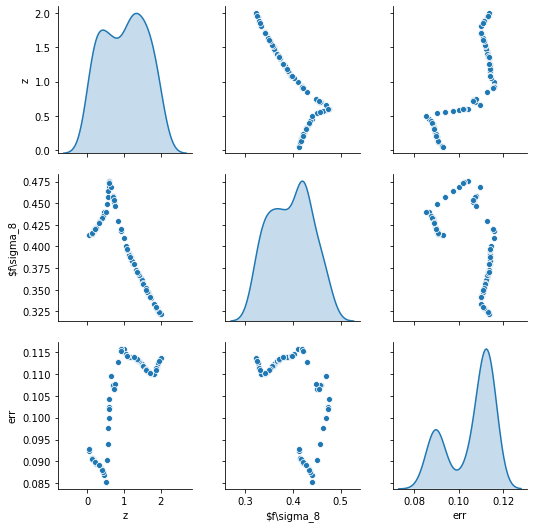

In [79]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100fs8mook.png")

In [30]:
4**4

256